In [1]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import os
import json
import shortuuid
import random
from torch.distributions.normal import Normal
from transformers import AutoModelForCausalLM, AutoTokenizer
import copy
from fastchat.conversation import get_conv_template

In [2]:
from datasets import load_dataset

qasper_dataset = load_dataset("tau/scrolls", "qasper")
"""
Options are: ["gov_report", "summ_screen_fd", "qmsum", "narrative_qa", "qasper", "quality", "contract_nli"]
"""

'\nOptions are: ["gov_report", "summ_screen_fd", "qmsum", "narrative_qa", "qasper", "quality", "contract_nli"]\n'

In [3]:
print(qasper_dataset['test'][0]['input'])

How big is the ANTISCAM dataset? 

Introduction
Considerable progress has been made building end-to-end dialog systems for collaborative tasks in which users cooperate with the system to achieve a common goal. Examples of collaborative tasks include making restaurant reservations and retrieving bus time-table information. Since users typically have clear and explicit intentions in collaborative tasks, existing systems commonly classify user utterances into pre-defined intents. In contrast, non-collaborative tasks are those where the users and the system do not strive to achieve the same goal. Examples of such tasks include deceiving attackers, persuading users to donate to a cause BIBREF1, and negotiating a product price BIBREF2, BIBREF3. In these tasks, users often perform complex actions that are beyond a simple set of pre-defined intents. In order to reach a common state, the user and the system need to build rapport and trust which naturally involves off-task content. Previous work

load model

In [2]:
# load model
model_path = '/mnt/data/users/Lang_Gao/proj/models/Llama-2-7b-chat-hf'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map='cuda:1')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:

# form inputs
def get_inputs(tokenizer, sentence):
    DEFAULT_TEMPLATE = get_conv_template("llama-2")
    # DEFAULT_TEMPLATE = get_conv_template("llama-2")
    DEFAULT_TEMPLATE.sep2 = DEFAULT_TEMPLATE.sep2.strip()
    DEFAULT_TEMPLATE.append_message(DEFAULT_TEMPLATE.roles[0], sentence)
    DEFAULT_TEMPLATE.append_message(DEFAULT_TEMPLATE.roles[1], None)
    prompt = DEFAULT_TEMPLATE.get_prompt()
    # print(prompt)
    indexed_tokens = tokenizer.encode(prompt)
    tokens_tensor = torch.tensor([indexed_tokens]).cuda()
    return tokens_tensor, indexed_tokens

def get_activation_hook(layer_name,activations):
    def hook(model, input, output):
        activations[layer_name] = output[0][-1, -1, :].cpu()
    return hook

def get_activations(model, tokenizer, prompt):
    inputs = get_inputs(tokenizer, prompt)
    with torch.no_grad():
        
        activations={}
        handles=[]
        for i, block in enumerate(model.model.layers):
            handles.append(block.register_forward_hook(get_activation_hook(i,activations)))
        p = model(inputs[0].to(model.device), output_attentions=True, return_dict=True)
        for hook in handles:
            hook.remove()
        return activations,p

def gen_model(model,tokenizer,prompt):
    input_ids = get_inputs(tokenizer, prompt)
    stop=len(input_ids[0])
    gen_config = model.generation_config
    with torch.no_grad():
        attn_masks = torch.ones_like(input_ids[0]).to(model.device)
        output_ids = model.generate(input_ids,
                                    attention_mask=attn_masks,
                                    generation_config=gen_config,
                                    pad_token_id=tokenizer.pad_token_id,
                                    # top_p=0.9,
                                    do_sample=False,
                                    # temperature=0.7
                                    )[0]
        
        gen_str=tokenizer.decode(output_ids[stop:]).strip()
    return gen_str

In [27]:
# input of different lengths in activation spaces.
from tqdm import tqdm
act_with_lengths=[]
for length in tqdm(range(1000)):
    sentence = "!" * length
    act_with_lengths.append(get_activations(model,tokenizer,sentence)[0]) # only preserve activations

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s]


In [ ]:
# get background activations
import json
bkg_prompts=json.load(open('/mnt/data/users/Lang_Gao/proj/Attack_Mechanisms/data/taxonomy/benign_questions/alpaca_prompts.json'))
bkg_prompts=[prompt['text'] for prompt in bkg_prompts]
bkg_prompts=sorted(bkg_prompts,key=lambda x:len(x))
len(bkg_prompts[-1])

'You are a smart assistant designed to help high school teachers come up with reading comprehension questions.\nGiven a piece of text, you must come up with a question and answer pair that can be used to test a student\'s reading comprehension abilities.\nWhen coming up with this question/answer pair, you must respond in the following format:\n```\n{{\n    "question": "$YOUR_QUESTION_HERE",\n    "answer": "$THE_ANSWER_HERE"\n}}\n```\nEverything between the ``` must be valid json.\nPlease come up with a question/answer pair, in the specified JSON format, for the following text:\n----------------\nPreviously, the use of dye-sub printing was limited to industrial or high-end commercial printing. Dye-sub photo printing has been used in medical imaging, graphic arts proofing, security, and broadcast-related applications. Today, it is extremely popular in event photography and photo booths or kiosks that require high-speed, on-demand printing.\n\nAlps Electric produced the first quality dye-

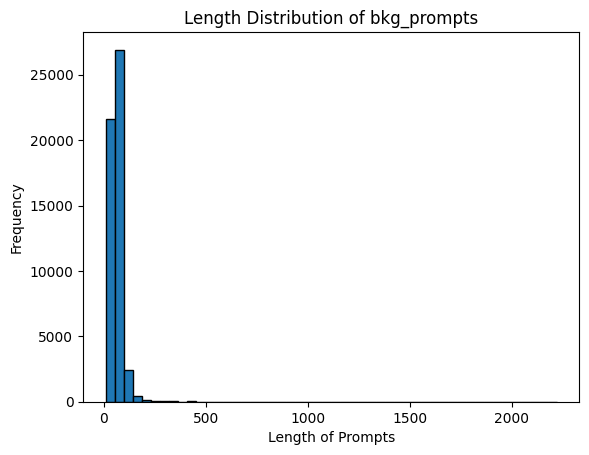

In [35]:
import matplotlib.pyplot as plt

# Calculate the lengths of each prompt
prompt_lengths = [len(prompt) for prompt in bkg_prompts]

# Plot the histogram
plt.hist(prompt_lengths, bins=50, edgecolor='black')
plt.title('Length Distribution of bkg_prompts')
plt.xlabel('Length of Prompts')
plt.ylabel('Frequency')
plt.show()

In [36]:
import random
bkg_subset=random.sample(bkg_prompts,5000)
bkg_acts=[]
for data in tqdm(bkg_subset):
    bkg_acts.append(get_activations(model,tokenizer,data)[0])

100%|██████████| 5000/5000 [14:22<00:00,  5.79it/s]


In [49]:
# 转换为 Tensor 列表格式
bkg_acts_tensor = [
    torch.stack([entry[key] for entry in bkg_acts])  # 每个 key 的所有样本按行堆叠
    for key in range(32)
]

act_with_lengths_tensor = [
    torch.stack([entry[key] for entry in act_with_lengths])  # 每个 key 的所有样本按行堆叠
    for key in range(32)
]

In [51]:
torch.save(bkg_acts_tensor, '/mnt/data/users/Lang_Gao/proj/Fairness_Mechanisms/tensors/bkg_acts_alpaca5000_tensor.pt')
torch.save(act_with_lengths_tensor, '/mnt/data/users/Lang_Gao/proj/Fairness_Mechanisms/tensors/random_!s_length_indicator_tensor.pt')

torch.Size([5000, 4096])

In [54]:
import torch
from mdscuda import MDS, minkowski_pairs

def compute_mds(bkg_acts_tensor, act_with_lengths_tensor, n_dims=2):
    """
    使用 mdscuda 和 torch 实现对 bkg_acts 和 act_with_lengths 的降维。

    Parameters:
        bkg_acts_tensor (list[torch.Tensor]): 背景向量集合，长度为 32 的列表，每个元素是形状为 (N, D) 的 torch.Tensor。
        act_with_lengths_tensor (list[torch.Tensor]): 带长度信息的向量集合，长度为 32 的列表，每个元素是形状为 (M, D) 的 torch.Tensor。
        n_dims (int): 降维后的目标维度，默认为 2。
    
    Returns:
        dict: 包含降维结果的中间结果对象，形式为：
              {
                  key: {
                      "bkg_reduced": torch.Tensor,  # bkg_acts 的降维结果
                      "act_reduced": torch.Tensor,  # act_with_lengths 的降维结果
                      "mds_r2": float              # MDS R² 值
                  },
                  ...
              }
    """
    results = {}

    # 遍历每个 key (0 到 31)
    for key in range(32):
        # 获取当前 key 对应的背景数据和 act 数据
        bkg_data = bkg_acts_tensor[key]  # 背景数据，形状为 (N, D)
        act_data = act_with_lengths_tensor[key]  # act 数据，形状为 (M, D)

        # 合并两个集合
        combined_data = torch.cat([bkg_data, act_data], dim=0)  # 合并为 (N + M, D)

        # 计算 pairwise 距离矩阵 (使用 minkowski_pairs)
        delta = minkowski_pairs(combined_data, sqform=False)  # 返回长格式的 pairwise 距离矩阵

        # 使用 mdscuda 的 MDS 类执行降维
        mds = MDS(n_dims=n_dims, verbosity=1)  # 创建 MDS 对象
        reduced_data = mds.fit(delta, calc_r2=True)  # 执行降维
        print(f"Key {key}: MDS R²: {mds.r2}")

        # 分离降维后的背景数据和 act 数据
        bkg_reduced = reduced_data[:len(bkg_data)]  # 前 N 行是 bkg 的降维结果
        act_reduced = reduced_data[len(bkg_data):]  # 后 M 行是 act 的降维结果

        # 保存降维结果和 R² 值
        results[key] = {
            "bkg_reduced": torch.tensor(bkg_reduced),  # 转换为 torch.Tensor
            "act_reduced": torch.tensor(act_reduced),  # 转换为 torch.Tensor
            "mds_r2": mds.r2
        }
    
    return results

In [62]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_mds_results(results):
    """
    可视化 MDS 的降维结果。每个 key 绘制一个子图，每行 8 个，共 8 行。
    act_reduced 的颜色由其所在行的下标决定：行下标越小颜色越绿，越大越黑。

    Parameters:
        results (dict): `compute_mds` 函数的返回值，形式为：
                        {
                            key: {
                                "bkg_reduced": torch.Tensor,  # bkg_acts 的降维结果
                                "act_reduced": torch.Tensor,  # act_with_lengths 的降维结果
                                "mds_r2": float              # MDS R² 值
                            },
                            ...
                        }
    """
    # 创建 8x8 网格布局
    fig, axes = plt.subplots(8, 8, figsize=(24, 24))  # 设置整体图形大小，每个子图大约为 3x3 英寸
    fig.suptitle('MDS Visualization by Key', fontsize=20)  # 全局标题

    # 遍历每个 key 和对应的子图
    for idx, (key, data) in enumerate(results.items()):
        row, col = divmod(idx, 8)  # 计算当前子图的行和列位置
        ax = axes[row, col]  # 获取对应的子图

        # 提取降维结果
        bkg_reduced = data["bkg_reduced"]  # 背景数据降维结果，形状为 (N, 2)
        act_reduced = data["act_reduced"]  # act 数据降维结果，形状为 (M, 2)
        mds_r2 = data["mds_r2"]  # R² 值

        # 绘制背景数据散点图 (蓝色)
        ax.scatter(bkg_reduced[:, 0], bkg_reduced[:, 1], c='blue', alpha=0.6, label='Background Data')

        # 根据 act_reduced 的行下标动态生成颜色
        num_points = act_reduced.size(0)  # act_reduced 的行数
        cmap = mcolors.LinearSegmentedColormap.from_list("green_to_black", ["green", "black"])  # 定义从绿色到黑色的颜色映射
        colors = [cmap(idx / (num_points - 1)) for idx in range(num_points)]  # 根据行下标分配颜色

        # 绘制 act 数据散点图
        ax.scatter(act_reduced[:, 0], act_reduced[:, 1], c=colors, alpha=0.8, label='Act Data')

        # 设置子图标题
        ax.set_title(f"Key {key} (R²={mds_r2:.2f})", fontsize=10)

        # 隐藏坐标轴刻度
        ax.set_xticks([])
        ax.set_yticks([])

        # 添加图例，仅在第一个子图显示
        if idx == 0:
            ax.legend(loc='upper right', fontsize=8)

    # 删除多余的子图（如果 key 的数量少于 32）
    for idx in range(len(results), 64):  # 总共 8x8=64 个子图
        row, col = divmod(idx, 8)
        fig.delaxes(axes[row, col])  # 删除未使用的子图

    # 自动调整布局
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整子图间距，避免重叠
    plt.show()

In [ ]:
# 执行降维
results = compute_mds(bkg_acts_tensor, act_with_lengths_tensor, n_dims=2)

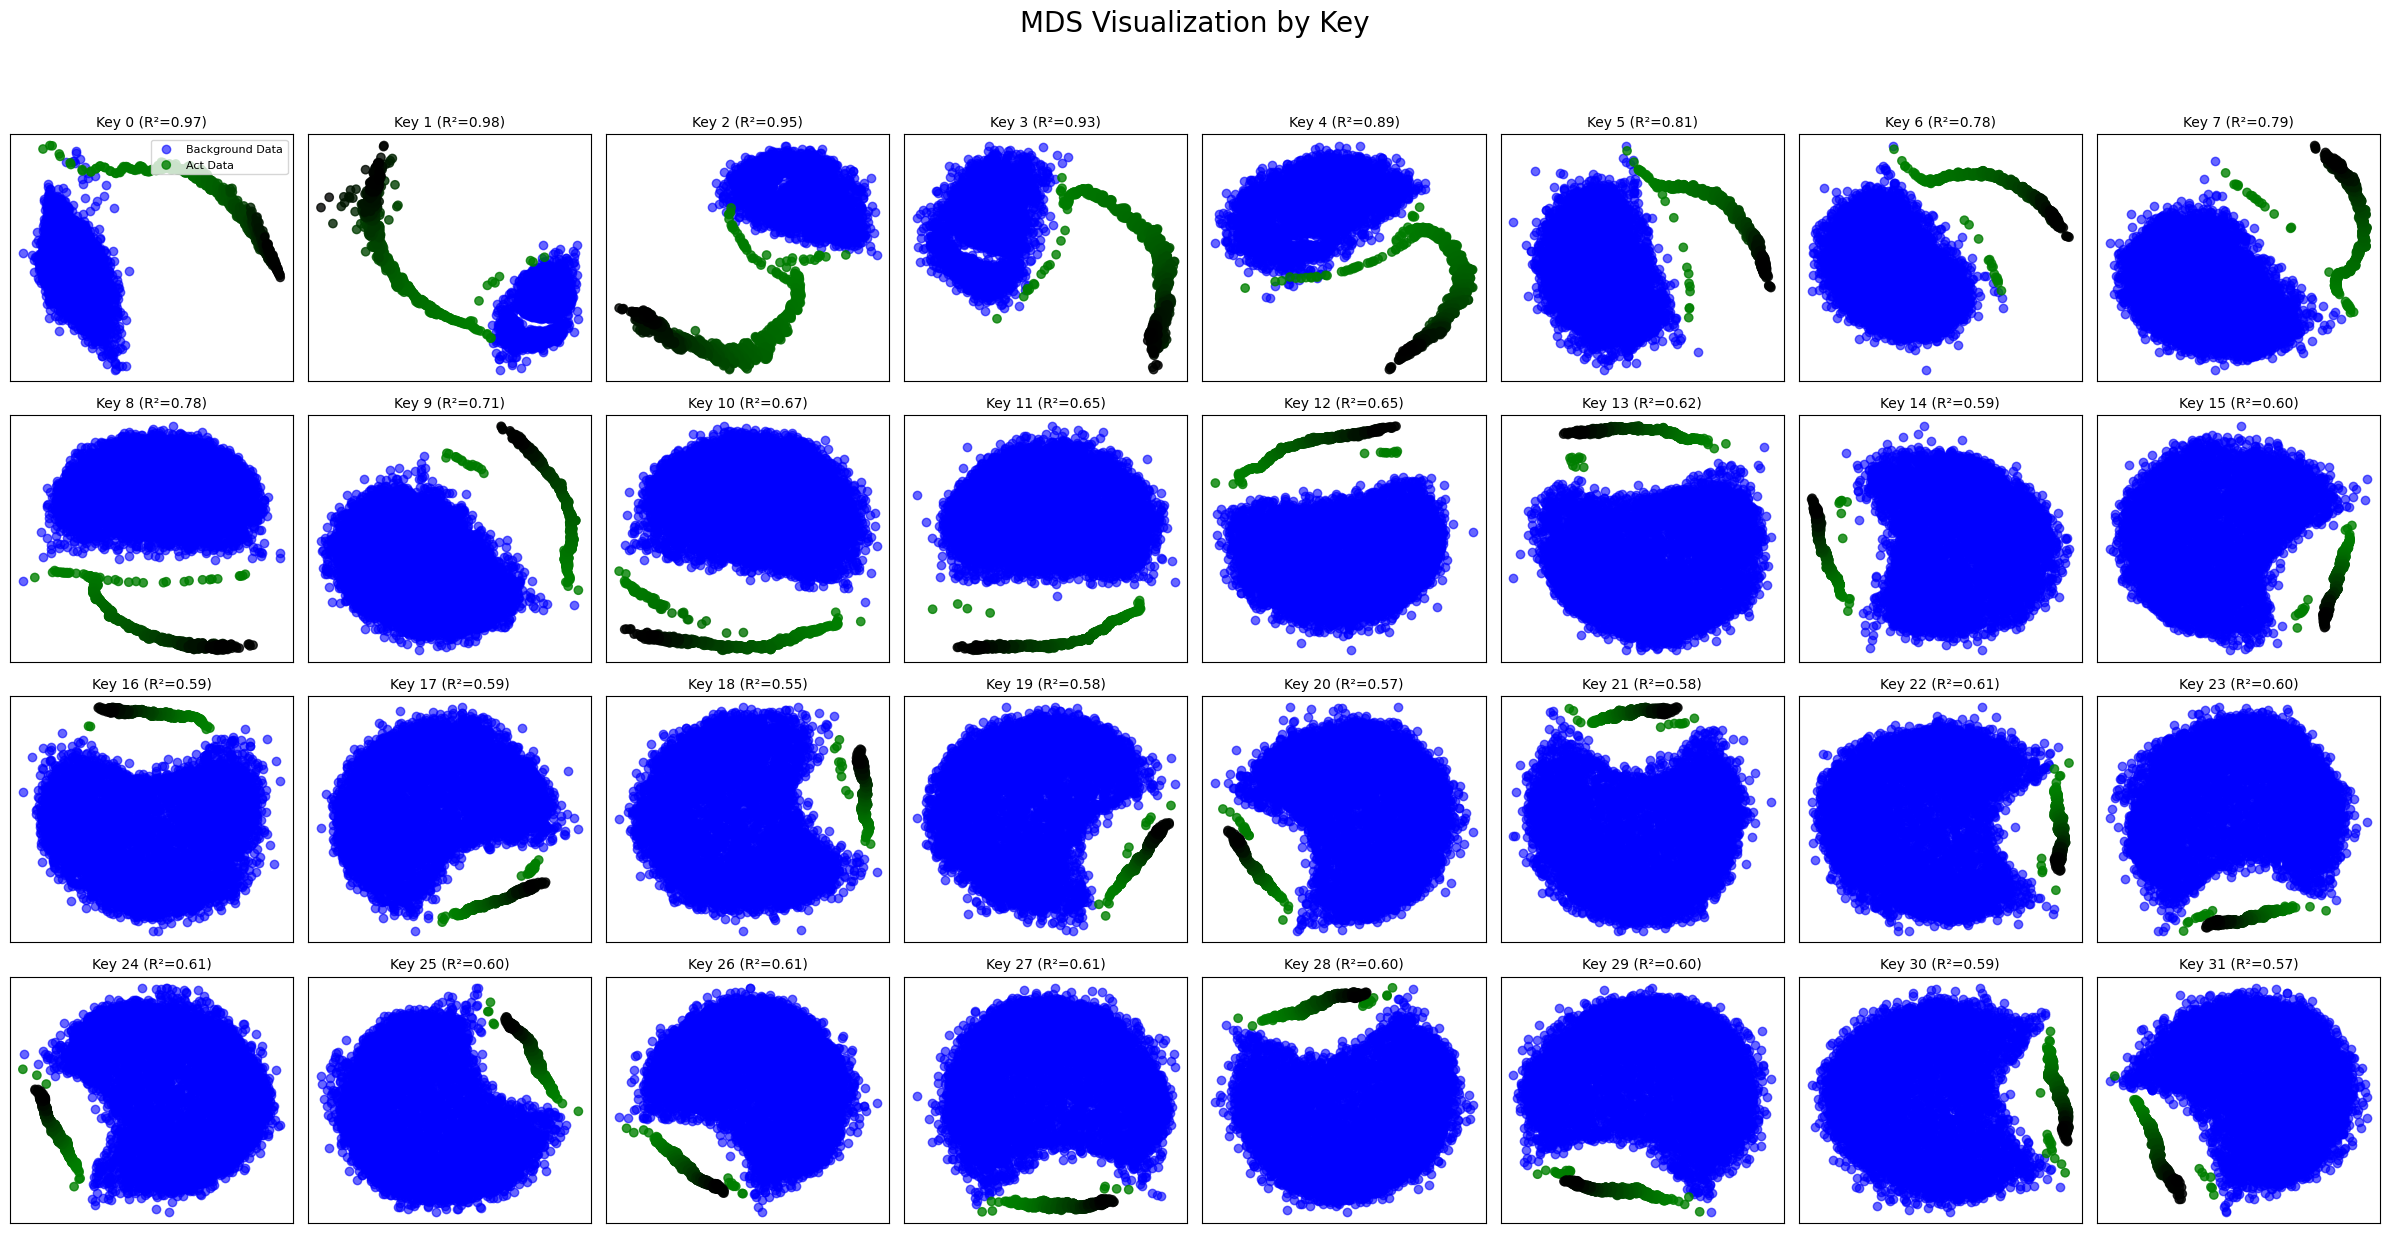

In [63]:
# 可视化结果
plot_mds_results(results)

directly show prompt distribution with lengths

In [8]:
# get background activations
import json
bkg_prompts=json.load(open('/mnt/data/users/Lang_Gao/proj/Fairness_Mechanisms/openwebtext_samples_lengthbalanced.json'))
bkg_prompts=sorted(bkg_prompts,key=lambda x:len(x))
len(bkg_prompts[0])

627

In [ ]:
bkg_acts=[]
for data in tqdm(bkg_prompts):
    bkg_acts.append(get_activations(model,tokenizer,data)[0])
# 转换为 Tensor 列表格式
bkg_acts_tensor = [
    torch.stack([entry[key] for entry in bkg_acts])  # 每个 key 的所有样本按行堆叠
    for key in range(32)
]